In [1]:
import os
import sys

from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F

import tiktoken
import itertools

import numpy as np
import pandas as pd
import pickle as pkl

sys.path.insert(1, '../../models/')
from model import GPT, GPTConfig

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [11]:
import matplotlib.pyplot as plt

# preprocessing
- process blimp data
- load model

In [23]:
all_dfs = []

for filename in os.listdir('.'):
    
    if not filename.endswith('.jsonl'):
        continue

    cur_df = pd.read_json(filename, lines=True)
    all_dfs.append(cur_df)

In [24]:
df = pd.concat(all_dfs).reset_index(drop=True)

In [33]:
checkpoint = torch.load('../../models/out/ckpt-5-5-2.5-48-mean-0.pt', map_location=device)
model_args = checkpoint['model_args']
model_args['position_dir'] = '../../models/gpt2-positions-5-5'

gptconf = GPTConfig(**model_args)
model = GPT(gptconf)

state_dict = checkpoint['model']
# fix the keys of the state dictionary :(
# honestly no idea how checkpoints sometimes get this prefix, have to debug more
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)

model.load_state_dict(state_dict, strict=False)
model.eval()

tokenizer = tiktoken.get_encoding('gpt2')
pad_token = tokenizer.encode('<|endoftext|>', allowed_special="all")[0]

number of parameters: 127.97M


# compute surprisals

In [178]:
@torch.no_grad()
def surprisal(model, tokens):
    """
    compute surprisal of a batch of tokens
    """
    B, L = tokens.shape
    context = tokens[:, 0].unsqueeze(1)
    surp = torch.zeros(B)
    
    for i in range(L - 1):
        
        logits, _, _, _, _ = model(context)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        
        next_token = tokens[:, i + 1]
        surp += -torch.log(probs[range(B), next_token])
        
        # append sampled index to the running sequence and continue
        context = torch.cat((context, tokens[:, i + 1].unsqueeze(1)), dim=1)

    return surp

In [182]:
def tokenize_batch(sents):
    tokens = tokenizer.encode_batch(sents, allowed_special = 'all')
    padded = list(zip(*itertools.zip_longest(*tokens, fillvalue=pad_token)))
    return torch.from_numpy(np.array(padded))

In [ ]:
good_surps = []
bad_surps = []

batch_size = 48
for i in tqdm(range(0, len(df), batch_size)):
    batch_df = df.iloc[i:i + batch_size]
    
    good_surps += list(surprisal(model, tokenize_batch(batch_df['sentence_good'])))
    bad_surps += list(surprisal(model, tokenize_batch(batch_df['sentence_bad'])))

In [ ]:
df['good_surps'] = good_surps
df['bad_surps'] = bad_surps
df['correct'] = df['good_surps'] < df['bad_surps']

In [ ]:
df.to_csv('blimp_results.csv')

# analysis

In [2]:
results = {'topo' : pd.read_csv('blimp_results.csv'), 'nontopo' : pd.read_csv('blimp_results_nontopo.csv')}

/var/folders/m6/32scpxtx647171scy78mkcxr0000gn/T/ipykernel_89483/703212275.py:1: DtypeWarning: Columns (14,15,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  results = {'topo' : pd.read_csv('blimp_results.csv'), 'nontopo' : pd.read_csv('blimp_results_nontopo.csv')}
/var/folders/m6/32scpxtx647171scy78mkcxr0000gn/T/ipykernel_89483/703212275.py:1: DtypeWarning: Columns (14,15,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  results = {'topo' : pd.read_csv('blimp_results.csv'), 'nontopo' : pd.read_csv('blimp_results_nontopo.csv')}


In [7]:
for key in results:
    results[key] = results[key][['sentence_good','sentence_bad', 'field', 'linguistics_term', 'UID', 'pairID', 'good_surps', 'bad_surps', 'correct']]
    results[key]['model'] = key

In [5]:
print('OVERALL:', results['nontopo']['correct'].mean())
print('---------')
print('BY CATEGORY:')
print(results['nontopo'].groupby('linguistics_term')['correct'].mean())

OVERALL: 0.7616716417910447
---------
BY CATEGORY:
linguistics_term
anaphor_agreement            0.904000
argument_structure           0.683571
binding                      0.771714
control_raising              0.716800
determiner_noun_agreement    0.866500
ellipsis                     0.699500
filler_gap_dependency        0.783143
irregular_forms              0.867500
island_effects               0.666250
npi_licensing                0.707571
quantifiers                  0.791250
s-selection                  0.701500
subject_verb_agreement       0.842333
Name: correct, dtype: float64


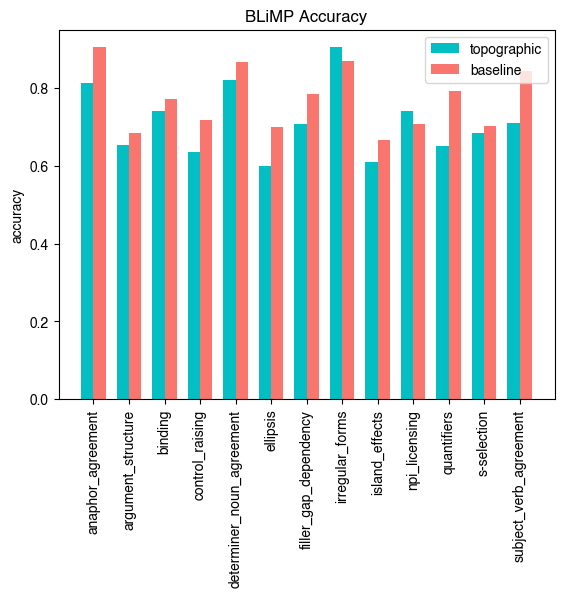

In [32]:
df = pd.concat([results['topo'], results['nontopo']])
acc = df.groupby(['linguistics_term', 'model'])['correct'].mean().unstack()

plt.rcParams['font.family'] = 'Helvetica'
viridis = plt.get_cmap('RdBu')

width = 0.35
x = np.arange(len(acc.index))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, acc['topo'], width, label='topographic', color='#03bfc4')
rects2 = ax.bar(x + width/2, acc['nontopo'], width, label='baseline', color='#f8766d')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy')
ax.set_title('BLiMP Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(acc.index, rotation=90)
ax.legend()

# Show plot
plt.show()